# 00__tss_assignment

in this notebook, i assign CAGE TSSs to transcripts (either Fantom-CAT assignments, when possible, or closest CAGE peak if there is one w/in 400bp). 

figures in this notebook:
- Fig S3C: overview of TSS assignments for library
- Fig S3D: overview of number of transcripts with multiple TSS assignments

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pb
import seaborn as sns
import sys

from scipy import stats

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
pb.helpers.set_bedtools_path(path="/PHShome/kz659/.conda/pkgs/bedtools-2.29.2-hc088bd4_0/bin")

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [4]:
def get_id_assignment(row):
    if not pd.isnull(row["cage_id_lv4_stringent"]):
        return row["cage_id_lv4_stringent"]
    elif not pd.isnull(row["cage_id_lv3_robust"]):
        return row["cage_id_lv3_robust"]
    elif not pd.isnull(row["cage_id_lv2_permissive"]):
        return row["cage_id_lv2_permissive"]
    elif not pd.isnull(row["cage_id_lv1_raw"]):
        return row["cage_id_lv1_raw"]
    else:
        return "none"

In [5]:
def get_id_assignment_type(row):
    if not pd.isnull(row["cage_id_lv4_stringent"]):
        return "lv4_stringent"
    elif not pd.isnull(row["cage_id_lv3_robust"]):
        return "lv3_robust"
    elif not pd.isnull(row["cage_id_lv2_permissive"]):
        return "lv2_permissive"
    elif not pd.isnull(row["cage_id_lv1_raw"]):
        return "lv1_raw"
    else:
        return "none"

In [6]:
def get_id_closest(row):
    if not pd.isnull(row["closest_cage_lv4_stringent"]):
        return row["closest_cage_lv4_stringent"]
    elif not pd.isnull(row["closest_cage_lv3_robust"]):
        return row["closest_cage_lv3_robust"]
    elif not pd.isnull(row["closest_cage_lv2_permissive"]):
        return row["closest_cage_lv2_permissive"]
    elif not pd.isnull(row["closest_cage_lv1_raw"]):
        return row["closest_cage_lv1_raw"]
    else:
        return "none"

In [7]:
def get_id_closest_type(row):
    if not pd.isnull(row["closest_cage_lv4_stringent"]):
        return "lv4_stringent"
    elif not pd.isnull(row["closest_cage_lv3_robust"]):
        return "lv3_robust"
    elif not pd.isnull(row["closest_cage_lv2_permissive"]):
        return "lv2_permissive"
    elif not pd.isnull(row["closest_cage_lv1_raw"]):
        return "lv1_raw"
    else:
        return "none"

In [8]:
def get_final_cage(row):
    if row.cage_id_assignment != "none" and row.cage_id_assignment_type != "lv1_raw":
        return row.cage_id_assignment
    elif row.cage_id_closest != "none":
        return row.cage_id_closest
    else:
        return "none"

In [9]:
def get_final_type(row):
    if row.cage_id_assignment != "none" and row.cage_id_assignment_type != "lv1_raw":
        return "FANTOM CAT assignment"
    elif row.cage_id_closest != "none":
        return "closest CAGE"
    else:
        return "annotation"

In [10]:
def get_final_level(row):
    if row.cage_id_assignment_type != "none" and row.cage_id_assignment_type != "lv1_raw":
        return row.cage_id_assignment_type
    elif row.cage_id_closest_type != "none":
        return row.cage_id_closest_type
    else:
        return "none"

In [11]:
def get_final_tss_start(row):
    if not pd.isnull(row.tss_start):
        return row.tss_start
    else:
        return row.start

In [12]:
def get_final_tss_end(row):
    if not pd.isnull(row.tss_end):
        return row.tss_end
    else:
        return row.end

## variables

In [13]:
expr_f = "../../../data/00__rna_seq/01__processed_results/rna_seq_results.tsv"

In [14]:
tss_f = "../../../misc/00__gene_metadata/gencode.v25lift37.annotation.TRANSCRIPT_TSS_MAP.txt"

In [15]:
fantom_dir = "../../../misc/03__fantom"

In [16]:
fantom_types = ["lv1_raw", "lv2_permissive", "lv3_robust", "lv4_stringent"]

In [17]:
fantom_bed_ending = "CAGE_cluster.bed.gz"

In [18]:
fantom_id_ending = "info_table.ID_mapping.tsv.gz"

In [19]:
pos_ctrl_dir = "../../../misc/04__pos_ctrls"

## 1. import data

In [20]:
fs = ["hESC_ctrls.txt", "endo_ctrls.txt", "meso_ctrls.txt"]
pos_ctrls = pd.DataFrame()
for f in fs:
    tmp = pd.read_table("%s/%s" % (pos_ctrl_dir, f), header=None)
    tmp.columns = ["gene_name"]
    tmp["lin"] = f.split("_")[0]
    pos_ctrls = pos_ctrls.append(tmp)
print(len(pos_ctrls))
pos_ctrls.sample(5)

485


,gene_name,lin
67,SPAG11A,meso
119,PLCXD3,endo
174,SYT6,hESC
8,MT1H,hESC
6,PLSCR2,endo


In [21]:
expr = pd.read_table(expr_f, sep="\t")
expr.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,meso_rep2,hESC_mean,endo_mean,meso_mean,overall_mean,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc
0,DIGIT,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.000000,0.025422,4.907468,4.784695,...,0.014741,0.012711,4.846082,0.007370,1.622054,expressed,0.008168525422325441,sleuth NA,2.529248,-0.007628
1,ENST00000000233.9_1,ENSG00000004059.10_2,ARF5,protein_coding,protein_coding,protein_coding,101.476958,102.386195,222.677573,197.586091,...,245.318970,101.931577,210.131832,204.374142,172.145850,expressed,0.0057874417654439295,0.0346694249326972,1.036458,0.996569
2,ENST00000000412.3,ENSG00000003056.3,M6PR,protein_coding,protein_coding,protein_coding,49.696030,46.457026,31.608496,36.350968,...,10.951882,48.076528,33.979732,20.552771,34.203010,expressed,0.00549724038022104,0.13894723887027402,-0.488514,-1.187160
3,ENST00000000442.10_1,ENSG00000173153.13_2,ESRRA,protein_coding,protein_coding,protein_coding,1.924618,3.493033,3.499700,2.419880,...,7.769760,2.708826,2.959790,7.600094,4.422903,expressed,0.814911561863725,0.0241642757995681,0.094461,1.213390
4,ENST00000001008.5_1,ENSG00000004478.7_1,FKBP4,protein_coding,protein_coding,protein_coding,71.840722,79.489420,33.770398,33.810736,...,68.012268,75.665071,33.790567,61.985019,57.146886,expressed,0.00160853874236564,0.0935556001786738,-1.139873,-0.283561


In [22]:
tss = pd.read_table(tss_f, sep="\t", header=None)
tss.columns = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chr", "start", "end", "strand"]
tss.head()

,transcript_id,gene_id,gene_name,transcript_name,chr,start,end,strand
0,ENST00000000233.9_1,ENSG00000004059.10_2,ARF5,ARF5-001,chr7,127228399,127228400.0,+
1,ENST00000000412.3,ENSG00000003056.3,M6PR,M6PR-001,chr12,9102550,9102551.0,-
2,ENST00000000442.10_1,ENSG00000173153.13_2,ESRRA,ESRRA-002,chr11,64073050,64073051.0,+
3,ENST00000001008.5_1,ENSG00000004478.7_1,FKBP4,FKBP4-001,chr12,2904119,2904120.0,+
4,ENST00000001146.6_1,ENSG00000003137.8_1,CYP26B1,CYP26B1-001,chr2,72375166,72375167.0,-


In [23]:
fantom_beds = {}
fantom_ids = {}
for t in fantom_types:
    bed_f = "%s/FANTOM_CAT.%s.%s" % (fantom_dir, t, fantom_bed_ending)
    ids_f = "%s/FANTOM_CAT.%s.%s" % (fantom_dir, t, fantom_id_ending)
    bed = pd.read_table(bed_f, sep="\t", header=None)
    bed.columns = ["chr", "peak_start", "peak_end", "peak_id", "score", "strand", "tss_start", "tss_end", "x", "y", "z", "a"]
    bed.drop(["x", "y", "z", "a"], axis=1, inplace=True)
    ids = pd.read_table(ids_f, sep="\t")
    ids.columns = ["gene_id", "transcript_id", "cage_id_%s" % t]
    fantom_beds[t] = bed
    fantom_ids[t] = ids

In [24]:
fantom_beds["lv1_raw"].head()

,chr,peak_start,peak_end,peak_id,score,strand,tss_start,tss_end
0,chr1,162484,162485,"chr1:162484..162485,-",38.48458,-,162484,162485
1,chr1,244166,244167,"chr1:244166..244167,-",41.37591,-,244166,244167
2,chr1,564452,564463,"chr1:564452..564463,+",62.80008,+,564462,564463
3,chr1,564474,564492,"chr1:564474..564492,-",58.69590,-,564474,564475
4,chr1,564571,564600,"chr1:564571..564600,+",60.30563,+,564588,564589


In [25]:
fantom_ids["lv1_raw"].head()

,gene_id,transcript_id,cage_id_lv1_raw
0,CATG00000000002.1,ENCT00000000144.1,"chr1:953489..953490,+"
1,CATG00000000003.1,ENCT00000000669.1,"chr1:4721909..4721910,+"
2,CATG00000000004.1,ENCT00000005542.1,"chr1:47082699..47082703,+"
3,CATG00000000004.1,ENCT00000005543.1,"chr1:47083734..47083735,+"
4,CATG00000000005.1,FTMT23800004167.1,"chr10:70828439..70828440,-"


## 2. filter transcripts to those expr in lineage & non-coding & pos ctrls

### get list of pos ctrls - top 100 transcripts in each lineage

In [26]:
hESC_manual_adds = ["FOXD3", "SMARCA4", "FOXO1", "FZD7", "POU5F1"]
hESC_manual_removes = ["ENST00000512818.5_1"]
endo_manual_adds = ["SMARCD3"]

In [27]:
expr_pos = pd.DataFrame()
for lin in ["hESC", "endo", "meso"]:
    genes = list(pos_ctrls[pos_ctrls["lin"] == lin]["gene_name"])
    expr_sub = expr[expr["gene_name"].isin(genes)]
    expr_samp = expr_sub.sort_values(by="%s_mean" % lin, ascending=False).head(100)
    if lin == "hESC":
        extra = expr[(expr["gene_name"].isin(hESC_manual_adds)) & (expr["threshold"] == "expressed") &
                     ~(expr["transcript_id"].isin(hESC_manual_removes))]
        expr_samp = expr_samp.append(extra)
    elif lin == "endo":
        extra = expr[(expr["gene_name"].isin(endo_manual_adds)) & (expr["threshold"] == "expressed")]
        expr_samp = expr_samp.append(extra)
    expr_pos = expr_pos.append(expr_samp)
print(len(expr_pos))
expr_pos.sample(5)

337


,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,meso_rep2,hESC_mean,endo_mean,meso_mean,overall_mean,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc
88770,ENST00000504426.5_1,ENSG00000138795.9_1,LEF1,protein_coding,protein_coding,protein_coding,0.000000,0.033064,0.000000,0.022564,...,47.545057,0.016532,0.011282,43.607585,14.545133,expressed,sleuth NA,0.00601966471041915,-0.007471,5.455561
16407,ENST00000356800.6_1,ENSG00000082014.16_1,SMARCD3,protein_coding,protein_coding,protein_coding,1.381276,1.635589,21.808564,19.427710,...,2.003028,1.508433,20.618137,1.592402,7.906324,expressed,0.000688912919494217,0.0845139839493209,3.107384,0.047503
5262,ENST00000276602.10_1,ENSG00000147601.13_1,TERF1,protein_coding,protein_coding,protein_coding,210.683836,215.790281,10.601282,10.370664,...,10.939220,213.237058,10.485973,11.085942,78.269657,expressed,0.000294335267131665,0.0028240853672495602,-4.221263,-4.147806
9093,ENST00000311575.5_1,ENSG00000174721.9_1,FGFBP3,protein_coding,protein_coding,protein_coding,40.066506,55.081910,1.093006,1.139003,...,6.665834,47.574208,1.116004,6.661126,18.450446,expressed,0.000530977560089283,0.0055344235708906205,-4.520776,-2.664562
33597,ENST00000409678.7_2,ENSG00000185269.11_2,NOTUM,protein_coding,protein_coding,protein_coding,0.583840,0.631290,7.876041,6.905129,...,487.299316,0.607565,7.390585,430.768555,146.255568,expressed,0.000688912919494217,0.0028240853672495602,2.383895,8.069237


In [28]:
expr.csf.value_counts()

protein_coding     145516
lncRNA_good_csf     25107
Name: csf, dtype: int64

In [29]:
expr_filt = expr[(expr["threshold"] == "expressed") & (expr["csf"] == "lncRNA_good_csf")].append(expr_pos)
len(expr_filt)

12948

## 3. merge TSS info

In [30]:
expr_tss = expr_filt.merge(tss, on=["transcript_id", "gene_id", "gene_name"], how="left")
expr_tss.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc,transcript_name,chr,start,end,strand
0,DIGIT,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.000000,0.025422,4.907468,4.784695,...,expressed,0.008168525422325441,sleuth NA,2.529248,-0.007628,NaN,NaN,NaN,NaN,NaN
1,ENST00000229465.10_1,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,promoter_overlap,3.818073,3.593770,9.239836,8.388961,...,expressed,0.00364130768320982,0.0710796055293791,1.060423,-0.522402,FLJ22447-002,chr14,62037258,62037259.0,+
2,ENST00000235290.7_1,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.252018,0.459512,0.050468,0.168700,...,expressed,0.18577218887026298,0.217517456894765,-0.289089,-0.235393,DLEU2-201,chr13,50656113,50656114.0,-
3,ENST00000255183.8_2,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,transcript_overlap,0.106856,0.154182,0.107185,0.148388,...,expressed,0.332357896649841,0.13450965034637,-0.003491,-0.068331,RP11-445H22.3-001,chr20,43292138,43292139.0,-
4,ENST00000279067.3_1,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,intergenic,0.090897,0.025084,0.010377,0.198384,...,expressed,0.40791507151659495,sleuth NA,0.061911,-0.081327,LINC00266-1-001,chr20,62921738,62921739.0,+


In [31]:
len(expr_tss)

12948

In [32]:
sum(pd.isnull(expr_tss["chr"]))

1

DIGIT is null because it was not in GENCODE file -- add manually

## 4. see if our transcripts have TSSs already assigned by fantom cat

In [33]:
expr_tss["transcript_id_short"] = expr_tss["transcript_id"].str.split("_", expand=True)[0]

In [34]:
for t in fantom_types:
    ids = fantom_ids[t]
    expr_tss = expr_tss.merge(ids, left_on="transcript_id_short", right_on="transcript_id", how="left", 
                              suffixes=["", "_tmp"])
    expr_tss.drop(["gene_id_tmp", "transcript_id_tmp"], axis=1, inplace=True)
expr_tss.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,transcript_name,chr,start,end,strand,transcript_id_short,cage_id_lv1_raw,cage_id_lv2_permissive,cage_id_lv3_robust,cage_id_lv4_stringent
0,DIGIT,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.000000,0.025422,4.907468,4.784695,...,NaN,NaN,NaN,NaN,NaN,DIGIT,NaN,NaN,NaN,NaN
1,ENST00000229465.10_1,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,promoter_overlap,3.818073,3.593770,9.239836,8.388961,...,FLJ22447-002,chr14,62037258,62037259.0,+,ENST00000229465.10,NaN,NaN,NaN,NaN
2,ENST00000235290.7_1,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.252018,0.459512,0.050468,0.168700,...,DLEU2-201,chr13,50656113,50656114.0,-,ENST00000235290.7,NaN,NaN,NaN,NaN
3,ENST00000255183.8_2,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,transcript_overlap,0.106856,0.154182,0.107185,0.148388,...,RP11-445H22.3-001,chr20,43292138,43292139.0,-,ENST00000255183.8,NaN,NaN,NaN,NaN
4,ENST00000279067.3_1,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,intergenic,0.090897,0.025084,0.010377,0.198384,...,LINC00266-1-001,chr20,62921738,62921739.0,+,ENST00000279067.3,NaN,NaN,NaN,NaN


In [35]:
expr_tss["cage_id_assignment"] = expr_tss.apply(get_id_assignment, axis=1)

In [36]:
expr_tss["cage_id_assignment_type"] = expr_tss.apply(get_id_assignment_type, axis=1)

In [37]:
expr_tss.drop(["cage_id_lv1_raw", "cage_id_lv2_permissive", "cage_id_lv3_robust", "cage_id_lv4_stringent"],
              axis=1, inplace=True)
expr_tss.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,endo_hESC_log2fc,meso_hESC_log2fc,transcript_name,chr,start,end,strand,transcript_id_short,cage_id_assignment,cage_id_assignment_type
0,DIGIT,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.000000,0.025422,4.907468,4.784695,...,2.529248,-0.007628,NaN,NaN,NaN,NaN,NaN,DIGIT,none,none
1,ENST00000229465.10_1,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,promoter_overlap,3.818073,3.593770,9.239836,8.388961,...,1.060423,-0.522402,FLJ22447-002,chr14,62037258,62037259.0,+,ENST00000229465.10,none,none
2,ENST00000235290.7_1,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.252018,0.459512,0.050468,0.168700,...,-0.289089,-0.235393,DLEU2-201,chr13,50656113,50656114.0,-,ENST00000235290.7,none,none
3,ENST00000255183.8_2,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,transcript_overlap,0.106856,0.154182,0.107185,0.148388,...,-0.003491,-0.068331,RP11-445H22.3-001,chr20,43292138,43292139.0,-,ENST00000255183.8,none,none
4,ENST00000279067.3_1,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,intergenic,0.090897,0.025084,0.010377,0.198384,...,0.061911,-0.081327,LINC00266-1-001,chr20,62921738,62921739.0,+,ENST00000279067.3,none,none


In [38]:
expr_tss.cage_id_assignment_type.value_counts()

none              6843
lv4_stringent     2862
lv3_robust        1727
lv2_permissive    1331
lv1_raw            185
Name: cage_id_assignment_type, dtype: int64

we can assign ~half of transcripts a fantom cat cage peak based on their existing annotations (though not sure we can trust those level 1 assignments)

## 5. find closest annotated CAGE peak

In [39]:
expr_tss = expr_tss[~pd.isnull(expr_tss["chr"])]
len(expr_tss)

12947

In [40]:
expr_tss_tmp = expr_tss[["chr", "start", "end", "transcript_id_short", "overall_mean", "strand"]]
expr_tss_tmp["start"] = expr_tss_tmp["start"].astype(int)
expr_tss_tmp["end"] = expr_tss_tmp["end"].astype(int)
expr_tss_tmp = expr_tss_tmp.sort_values(by=["chr", "start"])
expr_tss_tmp.head()

,chr,start,end,transcript_id_short,overall_mean,strand
3863,chr1,29554,29555,ENST00000473358.1,0.102665,+
3706,chr1,36072,36073,ENST00000461467.1,0.169188,-
4105,chr1,91104,91105,ENST00000495576.1,0.190915,-
3762,chr1,120931,120932,ENST00000466430.5,0.457390,-
3312,chr1,133565,133566,ENST00000453576.2,0.130751,-


In [41]:
# write this to csv temporarily to do bedtools intersections
expr_tss_tmp.to_csv("transcripts.tmp.bed", sep="\t", header=False, index=False)
expr_tss_tmp_bed = pb.BedTool("transcripts.tmp.bed")

In [42]:
# for every fantom type, intersect our transcripts with cage peaks
for t in fantom_types:
    fantom_bed_f = "%s/FANTOM_CAT.%s.%s" % (fantom_dir, t, fantom_bed_ending)
    fantom_bed = pb.BedTool(fantom_bed_f).to_dataframe()
    fantom_bed.columns = ["chr", "start", "end", "id", "score", "strand", "tss_start", "tss_end", "x", "y", "z", "a"]
    tss_bed = fantom_bed[["chr", "tss_start", "tss_end", "id", "score", "strand"]].sort_values(by=["chr", 
                                                                                                   "tss_start"])
    tss_bed.to_csv("cage.tmp.bed", sep="\t", header=False, index=False)
    tss_bed = pb.BedTool("cage.tmp.bed")
    closest = expr_tss_tmp_bed.closest(tss_bed, s=True, d=True).to_dataframe()
    closest.columns = ["t_chr", "t_start", "t_end", "t_id", "t_score", "t_strand",
                       "c_chr", "c_start", "c_end", "c_id", "c_score", "c_strand", "dist"]
    closest_sub = closest[closest["dist"] < 400][["t_id", "c_id", "c_score"]]
    
    # find max score within these
    closest_max = closest.groupby(["t_id"])["c_score"].agg("max").reset_index()
    closest_max_sub = closest_max.merge(closest_sub, on=["c_score", "t_id"], how="left")
    closest_max_sub.drop("c_score", axis=1, inplace=True)
    closest_max_sub.columns = ["transcript_id_short", "closest_cage_%s" % t]
    expr_tss = expr_tss.merge(closest_max_sub, on="transcript_id_short", how="left")

expr_tss.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,start,end,strand,transcript_id_short,cage_id_assignment,cage_id_assignment_type,closest_cage_lv1_raw,closest_cage_lv2_permissive,closest_cage_lv3_robust,closest_cage_lv4_stringent
0,ENST00000229465.10_1,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,promoter_overlap,3.818073,3.593770,9.239836,8.388961,...,62037258,62037259.0,+,ENST00000229465.10,none,none,"chr14:62037249..62037267,+","chr14:62037249..62037267,+","chr14:62037249..62037267,+","chr14:62037249..62037267,+"
1,ENST00000235290.7_1,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.252018,0.459512,0.050468,0.168700,...,50656113,50656114.0,-,ENST00000235290.7,none,none,"chr13:50656108..50656164,-","chr13:50656108..50656164,-","chr13:50656108..50656164,-","chr13:50656108..50656164,-"
2,ENST00000255183.8_2,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,transcript_overlap,0.106856,0.154182,0.107185,0.148388,...,43292138,43292139.0,-,ENST00000255183.8,none,none,NaN,NaN,NaN,NaN
3,ENST00000279067.3_1,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,intergenic,0.090897,0.025084,0.010377,0.198384,...,62921738,62921739.0,+,ENST00000279067.3,none,none,NaN,NaN,NaN,NaN
4,ENST00000294715.2,ENSG00000232527.3,RP11-14N7.2,lncRNA_good_csf,intergenic,intergenic,0.310121,0.000000,0.630823,0.000000,...,148928331,148928332.0,+,ENST00000294715.2,"chr1:148928291..148928331,+",lv4_stringent,"chr1:148928291..148928331,+","chr1:148928291..148928331,+","chr1:148928291..148928331,+","chr1:148928291..148928331,+"


In [43]:
expr_tss["cage_id_closest"] = expr_tss.apply(get_id_closest, axis=1)

In [44]:
expr_tss["cage_id_closest_type"] = expr_tss.apply(get_id_closest_type, axis=1)

In [45]:
expr_tss.drop(["closest_cage_lv1_raw", "closest_cage_lv2_permissive", "closest_cage_lv3_robust", 
               "closest_cage_lv4_stringent"], axis=1, inplace=True)
expr_tss.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,transcript_name,chr,start,end,strand,transcript_id_short,cage_id_assignment,cage_id_assignment_type,cage_id_closest,cage_id_closest_type
0,ENST00000229465.10_1,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,promoter_overlap,3.818073,3.593770,9.239836,8.388961,...,FLJ22447-002,chr14,62037258,62037259.0,+,ENST00000229465.10,none,none,"chr14:62037249..62037267,+",lv4_stringent
1,ENST00000235290.7_1,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.252018,0.459512,0.050468,0.168700,...,DLEU2-201,chr13,50656113,50656114.0,-,ENST00000235290.7,none,none,"chr13:50656108..50656164,-",lv4_stringent
2,ENST00000255183.8_2,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,transcript_overlap,0.106856,0.154182,0.107185,0.148388,...,RP11-445H22.3-001,chr20,43292138,43292139.0,-,ENST00000255183.8,none,none,none,none
3,ENST00000279067.3_1,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,intergenic,0.090897,0.025084,0.010377,0.198384,...,LINC00266-1-001,chr20,62921738,62921739.0,+,ENST00000279067.3,none,none,none,none
4,ENST00000294715.2,ENSG00000232527.3,RP11-14N7.2,lncRNA_good_csf,intergenic,intergenic,0.310121,0.000000,0.630823,0.000000,...,RP11-14N7.2-003,chr1,148928331,148928332.0,+,ENST00000294715.2,"chr1:148928291..148928331,+",lv4_stringent,"chr1:148928291..148928331,+",lv4_stringent


## 6. classify transcripts into different tss categories

In [46]:
expr_tss["cage_id_final"] = expr_tss.apply(get_final_cage, axis=1)

In [47]:
expr_tss["tss_type_final"] = expr_tss.apply(get_final_type, axis=1)

In [48]:
expr_tss["fantom_level_final"] = expr_tss.apply(get_final_level, axis=1)

In [49]:
expr_tss.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,end,strand,transcript_id_short,cage_id_assignment,cage_id_assignment_type,cage_id_closest,cage_id_closest_type,cage_id_final,tss_type_final,fantom_level_final
0,ENST00000229465.10_1,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,promoter_overlap,3.818073,3.593770,9.239836,8.388961,...,62037259.0,+,ENST00000229465.10,none,none,"chr14:62037249..62037267,+",lv4_stringent,"chr14:62037249..62037267,+",closest CAGE,lv4_stringent
1,ENST00000235290.7_1,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.252018,0.459512,0.050468,0.168700,...,50656114.0,-,ENST00000235290.7,none,none,"chr13:50656108..50656164,-",lv4_stringent,"chr13:50656108..50656164,-",closest CAGE,lv4_stringent
2,ENST00000255183.8_2,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,transcript_overlap,0.106856,0.154182,0.107185,0.148388,...,43292139.0,-,ENST00000255183.8,none,none,none,none,none,annotation,none
3,ENST00000279067.3_1,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,intergenic,0.090897,0.025084,0.010377,0.198384,...,62921739.0,+,ENST00000279067.3,none,none,none,none,none,annotation,none
4,ENST00000294715.2,ENSG00000232527.3,RP11-14N7.2,lncRNA_good_csf,intergenic,intergenic,0.310121,0.000000,0.630823,0.000000,...,148928332.0,+,ENST00000294715.2,"chr1:148928291..148928331,+",lv4_stringent,"chr1:148928291..148928331,+",lv4_stringent,"chr1:148928291..148928331,+",FANTOM CAT assignment,lv4_stringent


## 7. get TSSs for cage peaks

In [50]:
expr_tss = expr_tss.merge(fantom_beds["lv1_raw"][["peak_id", "tss_start", "tss_end"]], left_on="cage_id_final",
                          right_on="peak_id", how="left")
expr_tss.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,cage_id_assignment,cage_id_assignment_type,cage_id_closest,cage_id_closest_type,cage_id_final,tss_type_final,fantom_level_final,peak_id,tss_start,tss_end
0,ENST00000229465.10_1,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,promoter_overlap,3.818073,3.593770,9.239836,8.388961,...,none,none,"chr14:62037249..62037267,+",lv4_stringent,"chr14:62037249..62037267,+",closest CAGE,lv4_stringent,"chr14:62037249..62037267,+",62037256.0,62037257.0
1,ENST00000235290.7_1,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.252018,0.459512,0.050468,0.168700,...,none,none,"chr13:50656108..50656164,-",lv4_stringent,"chr13:50656108..50656164,-",closest CAGE,lv4_stringent,"chr13:50656108..50656164,-",50656126.0,50656127.0
2,ENST00000255183.8_2,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,transcript_overlap,0.106856,0.154182,0.107185,0.148388,...,none,none,none,none,none,annotation,none,NaN,NaN,NaN
3,ENST00000279067.3_1,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,intergenic,0.090897,0.025084,0.010377,0.198384,...,none,none,none,none,none,annotation,none,NaN,NaN,NaN
4,ENST00000294715.2,ENSG00000232527.3,RP11-14N7.2,lncRNA_good_csf,intergenic,intergenic,0.310121,0.000000,0.630823,0.000000,...,"chr1:148928291..148928331,+",lv4_stringent,"chr1:148928291..148928331,+",lv4_stringent,"chr1:148928291..148928331,+",FANTOM CAT assignment,lv4_stringent,"chr1:148928291..148928331,+",148928312.0,148928313.0


In [51]:
expr_tss["final_start"] = expr_tss.apply(get_final_tss_start, axis=1)

In [52]:
expr_tss["final_end"] = expr_tss.apply(get_final_tss_end, axis=1)
expr_tss.head()

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,cage_id_closest,cage_id_closest_type,cage_id_final,tss_type_final,fantom_level_final,peak_id,tss_start,tss_end,final_start,final_end
0,ENST00000229465.10_1,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,promoter_overlap,3.818073,3.593770,9.239836,8.388961,...,"chr14:62037249..62037267,+",lv4_stringent,"chr14:62037249..62037267,+",closest CAGE,lv4_stringent,"chr14:62037249..62037267,+",62037256.0,62037257.0,6.20373e+07,62037257.0
1,ENST00000235290.7_1,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.252018,0.459512,0.050468,0.168700,...,"chr13:50656108..50656164,-",lv4_stringent,"chr13:50656108..50656164,-",closest CAGE,lv4_stringent,"chr13:50656108..50656164,-",50656126.0,50656127.0,5.06561e+07,50656127.0
2,ENST00000255183.8_2,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,transcript_overlap,0.106856,0.154182,0.107185,0.148388,...,none,none,none,annotation,none,NaN,NaN,NaN,43292138,43292139.0
3,ENST00000279067.3_1,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,intergenic,0.090897,0.025084,0.010377,0.198384,...,none,none,none,annotation,none,NaN,NaN,NaN,62921738,62921739.0
4,ENST00000294715.2,ENSG00000232527.3,RP11-14N7.2,lncRNA_good_csf,intergenic,intergenic,0.310121,0.000000,0.630823,0.000000,...,"chr1:148928291..148928331,+",lv4_stringent,"chr1:148928291..148928331,+",FANTOM CAT assignment,lv4_stringent,"chr1:148928291..148928331,+",148928312.0,148928313.0,1.48928e+08,148928313.0


In [53]:
expr_tss.columns

Index(['transcript_id', 'gene_id', 'gene_name', 'csf', 'cleaner_gene_biotype',
       'cleaner_transcript_biotype', 'hESC_rep1', 'hESC_rep2', 'endo_rep1',
       'endo_rep2', 'meso_rep1', 'meso_rep2', 'hESC_mean', 'endo_mean',
       'meso_mean', 'overall_mean', 'threshold', 'qval_hESC_endo',
       'qval_hESC_meso', 'endo_hESC_log2fc', 'meso_hESC_log2fc',
       'transcript_name', 'chr', 'start', 'end', 'strand',
       'transcript_id_short', 'cage_id_assignment', 'cage_id_assignment_type',
       'cage_id_closest', 'cage_id_closest_type', 'cage_id_final',
       'tss_type_final', 'fantom_level_final', 'peak_id', 'tss_start',
       'tss_end', 'final_start', 'final_end'],
      dtype='object')

In [54]:
expr_tss_final = expr_tss[["transcript_id", "transcript_name", "gene_id", "gene_name", "csf", "cleaner_gene_biotype",
                           "hESC_mean", "endo_mean", "meso_mean", "overall_mean", "threshold",
                           "qval_hESC_endo", "qval_hESC_meso", "endo_hESC_log2fc", "meso_hESC_log2fc",
                           "chr", "final_start", "final_end", "strand", "cage_id_final", "tss_type_final", 
                           "fantom_level_final"]]
expr_tss_final["final_start"] = expr_tss_final["final_start"].astype(int)
expr_tss_final["final_end"] = expr_tss_final["final_end"].astype(int)
expr_tss_final.head()

,transcript_id,transcript_name,gene_id,gene_name,csf,cleaner_gene_biotype,hESC_mean,endo_mean,meso_mean,overall_mean,...,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc,chr,final_start,final_end,strand,cage_id_final,tss_type_final,fantom_level_final
0,ENST00000229465.10_1,FLJ22447-002,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,3.705921,8.814398,2.276319,4.932213,...,0.0710796055293791,1.060423,-0.522402,chr14,62037256,62037257,+,"chr14:62037249..62037267,+",closest CAGE,lv4_stringent
1,ENST00000235290.7_1,DLEU2-201,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,0.355765,0.109584,0.151659,0.205669,...,0.217517456894765,-0.289089,-0.235393,chr13,50656126,50656127,-,"chr13:50656108..50656164,-",closest CAGE,lv4_stringent
2,ENST00000255183.8_2,RP11-445H22.3-001,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,0.130519,0.127787,0.078222,0.112176,...,0.13450965034637,-0.003491,-0.068331,chr20,43292138,43292139,-,none,annotation,none
3,ENST00000279067.3_1,LINC00266-1-001,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,0.057990,0.104381,0.000000,0.054124,...,sleuth NA,0.061911,-0.081327,chr20,62921738,62921739,+,none,annotation,none
4,ENST00000294715.2,RP11-14N7.2-003,ENSG00000232527.3,RP11-14N7.2,lncRNA_good_csf,intergenic,0.155061,0.315412,0.289688,0.253387,...,sleuth NA,0.187546,0.159054,chr1,148928312,148928313,+,"chr1:148928291..148928331,+",FANTOM CAT assignment,lv4_stringent


## 8. clean up column names

In [55]:
expr_tss_final.columns = ["transcript_id", "transcript_name", "gene_id", "gene_name", "csf", "cleaner_biotype",
                           "hESC_mean", "endo_mean", "meso_mean", "overall_mean", "threshold",
                           "qval_hESC_endo", "qval_hESC_meso", "endo_hESC_log2fc", "meso_hESC_log2fc",
                           "chr", "tss_start", "tss_end", "strand", "cage_id", "tss_type", "fantom_level"]
expr_tss_final = expr_tss_final[["transcript_id", "transcript_name", "gene_id", "gene_name", "csf", "cleaner_biotype",
                                 "hESC_mean", "endo_mean", "meso_mean", "overall_mean", "threshold",
                                 "qval_hESC_endo", "qval_hESC_meso", "endo_hESC_log2fc", "meso_hESC_log2fc",
                                 "chr", "tss_start", "tss_end", "strand", "tss_type", "fantom_level", "cage_id"]]
expr_tss_final.head()

,transcript_id,transcript_name,gene_id,gene_name,csf,cleaner_biotype,hESC_mean,endo_mean,meso_mean,overall_mean,...,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc,chr,tss_start,tss_end,strand,tss_type,fantom_level,cage_id
0,ENST00000229465.10_1,FLJ22447-002,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,3.705921,8.814398,2.276319,4.932213,...,0.0710796055293791,1.060423,-0.522402,chr14,62037256,62037257,+,closest CAGE,lv4_stringent,"chr14:62037249..62037267,+"
1,ENST00000235290.7_1,DLEU2-201,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,0.355765,0.109584,0.151659,0.205669,...,0.217517456894765,-0.289089,-0.235393,chr13,50656126,50656127,-,closest CAGE,lv4_stringent,"chr13:50656108..50656164,-"
2,ENST00000255183.8_2,RP11-445H22.3-001,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,0.130519,0.127787,0.078222,0.112176,...,0.13450965034637,-0.003491,-0.068331,chr20,43292138,43292139,-,annotation,none,none
3,ENST00000279067.3_1,LINC00266-1-001,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,0.057990,0.104381,0.000000,0.054124,...,sleuth NA,0.061911,-0.081327,chr20,62921738,62921739,+,annotation,none,none
4,ENST00000294715.2,RP11-14N7.2-003,ENSG00000232527.3,RP11-14N7.2,lncRNA_good_csf,intergenic,0.155061,0.315412,0.289688,0.253387,...,sleuth NA,0.187546,0.159054,chr1,148928312,148928313,+,FANTOM CAT assignment,lv4_stringent,"chr1:148928291..148928331,+"


In [56]:
expr_tss_final.drop_duplicates(inplace=True)
len(expr_tss_final)

12945

In [57]:
expr_tss_final.groupby(["transcript_id"])["tss_start"].agg("count").reset_index().sort_values(by="tss_start", ascending=False).head()

,transcript_id,tss_start
0,ENST00000009180.8_1,1
8634,ENST00000581213.1_1,1
8624,ENST00000581067.1_1,1
8625,ENST00000581083.1_1,1
8626,ENST00000581117.1_1,1


## 9. plot the #s of tss categories

In [58]:
expr_tss_final_grp = expr_tss_final.groupby(["tss_type", "fantom_level"])["cage_id"].agg("count").unstack()
expr_tss_final_grp

fantom_level,lv1_raw,lv2_permissive,lv3_robust,lv4_stringent,none
tss_type,,,,,
FANTOM CAT assignment,NaN,1331.0,1727.0,2861.0,NaN
annotation,NaN,NaN,NaN,NaN,3814.0
closest CAGE,47.0,334.0,613.0,2218.0,NaN


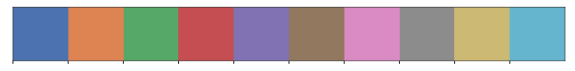

In [59]:
sns.palplot(sns.color_palette("deep"))

In [60]:
pal = {"none": "gray", "lv1_raw": sns.color_palette()[3], "lv2_permissive": sns.color_palette()[1],
       "lv3_robust": sns.color_palette()[0], "lv4_stringent": sns.color_palette()[2]}
colors = [sns.color_palette()[3], sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[2], "gray"]

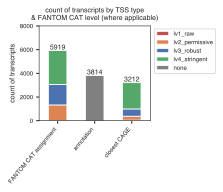

In [61]:
ax = expr_tss_final_grp.plot.bar(stacked=True, color=colors, figsize=(2, 1.75))

# annotate totals
expr_tss_final_sum = expr_tss_final_grp.sum(axis=1).reset_index()
for i, x in enumerate(list(expr_tss_final_sum["tss_type"])):
    y = expr_tss_final_sum[expr_tss_final_sum["tss_type"] == x][0].iloc[0]
    ax.text(i, y+100, int(y), horizontalalignment="center")
    
ax.set_ylim((0, 8000))
ax.set_ylabel("count of transcripts")
ax.set_xlabel("")
ax.set_title("count of transcripts by TSS type\n& FANTOM CAT level (where applicable)")
ax.set_xticklabels(["FANTOM CAT assignment", "annotation", "closest CAGE"], rotation=50, ha="right", va="top")
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.savefig("FigS3C.pdf", dpi="figure", bbox_inches="tight")

## 10. count # of expressed TSSs per gene

In [62]:
expr_tss_final.head()

,transcript_id,transcript_name,gene_id,gene_name,csf,cleaner_biotype,hESC_mean,endo_mean,meso_mean,overall_mean,...,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc,chr,tss_start,tss_end,strand,tss_type,fantom_level,cage_id
0,ENST00000229465.10_1,FLJ22447-002,ENSG00000232774.7_2,FLJ22447,lncRNA_good_csf,promoter_overlap,3.705921,8.814398,2.276319,4.932213,...,0.0710796055293791,1.060423,-0.522402,chr14,62037256,62037257,+,closest CAGE,lv4_stringent,"chr14:62037249..62037267,+"
1,ENST00000235290.7_1,DLEU2-201,ENSG00000231607.9_2,DLEU2,lncRNA_good_csf,promoter_overlap,0.355765,0.109584,0.151659,0.205669,...,0.217517456894765,-0.289089,-0.235393,chr13,50656126,50656127,-,closest CAGE,lv4_stringent,"chr13:50656108..50656164,-"
2,ENST00000255183.8_2,RP11-445H22.3-001,ENSG00000283440.1_1,RP11-445H22.3,lncRNA_good_csf,transcript_overlap,0.130519,0.127787,0.078222,0.112176,...,0.13450965034637,-0.003491,-0.068331,chr20,43292138,43292139,-,annotation,none,none
3,ENST00000279067.3_1,LINC00266-1-001,ENSG00000149656.8_1,LINC00266-1,lncRNA_good_csf,intergenic,0.057990,0.104381,0.000000,0.054124,...,sleuth NA,0.061911,-0.081327,chr20,62921738,62921739,+,annotation,none,none
4,ENST00000294715.2,RP11-14N7.2-003,ENSG00000232527.3,RP11-14N7.2,lncRNA_good_csf,intergenic,0.155061,0.315412,0.289688,0.253387,...,sleuth NA,0.187546,0.159054,chr1,148928312,148928313,+,FANTOM CAT assignment,lv4_stringent,"chr1:148928291..148928331,+"


In [63]:
count_per_gene = expr_tss_final.groupby("gene_name")["transcript_id"].agg("count").reset_index()
count_per_gene.sample(5)

,gene_name,transcript_id
799,AJ011932.1,1
7274,RP11-96B5.3,1
3744,RP11-122G18.10,1
4827,RP11-324D17.2,1
7059,RP11-849N15.4,1


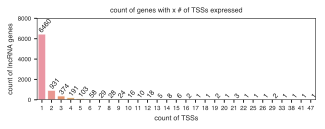

In [64]:
plt.figure(figsize=(5, 1.5))
ax = sns.countplot(x="transcript_id", data=count_per_gene)

# annotate totals
for p in ax.patches:
    w = p.get_width()
    x = p.get_x()
    y = p.get_y()
    h = p.get_height()
    
    ax.text(x + 0.75, h, int(h), ha="center", va="bottom", rotation=50) 

ax.set_ylim((0, 8000))
plt.title("count of genes with x # of TSSs expressed")
plt.xlabel("count of TSSs")
plt.ylabel("count of lncRNA genes")
plt.savefig("FigS3D.pdf", dpi="figure", bbox_inches="tight")

In [65]:
count_per_gene.sort_values(by="transcript_id", ascending=False).head(10)

,gene_name,transcript_id
3182,PCBP1-AS1,47
2684,LINC00969,41
8119,TTN-AS1,38
4648,RP11-295P9.3,33
2191,GAS5,29
2965,LRRC75A-AS1,29
94,AC005154.6,26
7968,SNHG1,25
1075,CCDC18-AS1,22
8093,TPT1-AS1,21


In [66]:
expr_tss_final[expr_tss_final["gene_name"] == "PABPC1L2B-AS1"]

,transcript_id,transcript_name,gene_id,gene_name,csf,cleaner_biotype,hESC_mean,endo_mean,meso_mean,overall_mean,...,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc,chr,tss_start,tss_end,strand,tss_type,fantom_level,cage_id
757,ENST00000416989.2_1,PABPC1L2B-AS1-001,ENSG00000226725.2_1,PABPC1L2B-AS1,lncRNA_good_csf,promoter_overlap,0.471426,0.004088,0.132076,0.20253,...,0.0763182177434886,-0.551329,-0.378243,chrX,72222694,72222695,-,annotation,none,none
3378,ENST00000454388.1_1,PABPC1L2B-AS1-001,ENSG00000231963.1_1,PABPC1L2B-AS1,lncRNA_good_csf,promoter_overlap,0.471426,0.004088,0.132076,0.20253,...,0.0763182177434886,-0.551329,-0.378243,chrX,72299351,72299352,+,FANTOM CAT assignment,lv2_permissive,"chrX:72299349..72299374,+"


In [67]:
expr_tss_morethan1 = expr_tss_final[expr_tss_final["gene_name"].isin(count_per_gene[count_per_gene["transcript_id"]>1]["gene_name"])]
hESC_std_per_gene = expr_tss_morethan1.groupby(["gene_name"])["hESC_mean"].agg(["std", "count"]).reset_index()
endo_std_per_gene = expr_tss_morethan1.groupby(["gene_name"])["endo_mean"].agg(["std", "count"]).reset_index()
meso_std_per_gene = expr_tss_morethan1.groupby(["gene_name"])["meso_mean"].agg(["std", "count"]).reset_index()
hESC_std_per_gene.head()

,gene_name,std,count
0,A1BG-AS1,0.132979,4
1,AASS,87.269440,3
2,ABCA9-AS1,0.275175,3
3,AC002117.1,0.062357,2
4,AC002456.2,0.169331,3


Text(0.5, 1.0, 'expression variance for genes with >1 TSS')

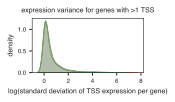

In [68]:
fig = plt.figure(figsize=(2, 1))
sns.kdeplot(np.log(hESC_std_per_gene["std"]+1), label="hESC", shade=True)
sns.kdeplot(np.log(endo_std_per_gene["std"]+1), label="endo", shade=True)
sns.kdeplot(np.log(meso_std_per_gene["std"]+1), label="meso", shade=True)
plt.xlabel("log(standard deviation of TSS expression per gene)")
plt.ylabel("density")
plt.title("expression variance for genes with >1 TSS")
#plt.savefig("expr_var_for_genes_with_mult_tss", dpi="figure", bbox_inches="tight")

## 12. write final files

In [69]:
filename = "../../../data/01__design/00__tss_list/all_lncRNA_and_ctrl_TSSs_final.txt"
expr_tss_final.to_csv(filename, sep="\t", index=False)

In [70]:
filename = "../../../misc/04__pos_ctrls/top_100_picked_positive_ctrls.txt"
expr_pos = expr_pos.merge(pos_ctrls, on="gene_name")
expr_pos.to_csv(filename, sep="\t", index=False)

In [71]:
expr_pos[expr_pos["gene_name"]=="CER1"]

,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,hESC_mean,endo_mean,meso_mean,overall_mean,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc,lin
107,ENST00000380911.3_1,ENSG00000147869.4_1,CER1,protein_coding,protein_coding,protein_coding,11.077543,1.191445,11006.427648,11706.613119,...,6.134494,11356.520384,0.844438,3787.833105,expressed,0.004724897258368679,0.305097229440153,10.636549,-1.95163,endo


In [72]:
len(expr_pos)

319

In [73]:
!rm cage.tmp.bed

In [74]:
!rm transcripts.tmp.bed